# Hyderabad Salaried Employees (Agglomerative Clustering)

## Importing Libraries

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
# Core Libraries
import pandas as pd
import numpy as np
import re

In [32]:
# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [33]:
# Preprocessing & ML Libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [34]:
# Style Configurations
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150

## Load and Inspect Dataset

In [37]:
df = pd.read_csv("hyderabad-salaried-employees.csv")
print("Dataset loaded successfully.")

print("\n--- Initial Data Overview ---")
print("Shape of dataset:", df.shape)
print("\nColumns:", df.columns.tolist())



Dataset loaded successfully.

--- Initial Data Overview ---
Shape of dataset: (28847, 9)

Columns: ['candidateName', 'companyName', 'designation', 'experienceMas', 'locationCurrentMas', 'qualificationMas', 'qualificationMas2', 'salary', 'Category']


In [38]:
print("\nSample Data:")
(df.head())




Sample Data:


,candidateName,companyName,designation,experienceMas,locationCurrentMas,qualificationMas,qualificationMas2,salary,Category
0,Ruchismita Dash,Amdocs,Software Developer,2 Year(s) 1 Month(s),Hyderabad/ Secunderabad,BE/ B.Tech (Engineering),NaN,Rs. 6.71 lacs,HYDERABAD-SALARIED
1,MANISHA DAS,APOLLO HOSPITALS ENTERPRISES LIMITED,SENIOR EXECUTIVE-OPERATIONS,5 Year(s) 9 Month(s),Hyderabad/ Secunderabad,MBA/ PGDM,B.Pharm. (Pharmacy),Rs. 5.0 lacs,HYDERABAD-SALARIED
2,C J GEETHA PRIYA,propertyoneshop.com,System Administrator,4 Year(s) 4 Month(s),Hyderabad/ Secunderabad,B.Com. (Commerce),NaN,Rs. 84.0 lacs,HYDERABAD-SALARIED
3,SRIKANTH,Axis Bank Ltd,NaN,7 Year(s) 11 Month(s),Hyderabad/ Secunderabad,NaN,MBA/ PGDM,Rs. 7.0 lacs,HYDERABAD-SALARIED
4,Madduri Srinivas,CTS,Associate Projects,6 Year(s) 8 Month(s),Hyderabad/ Secunderabad,B.Com. (Commerce),MCA/ PGDCA,Rs. 8.05 lacs,HYDERABAD-SALARIED


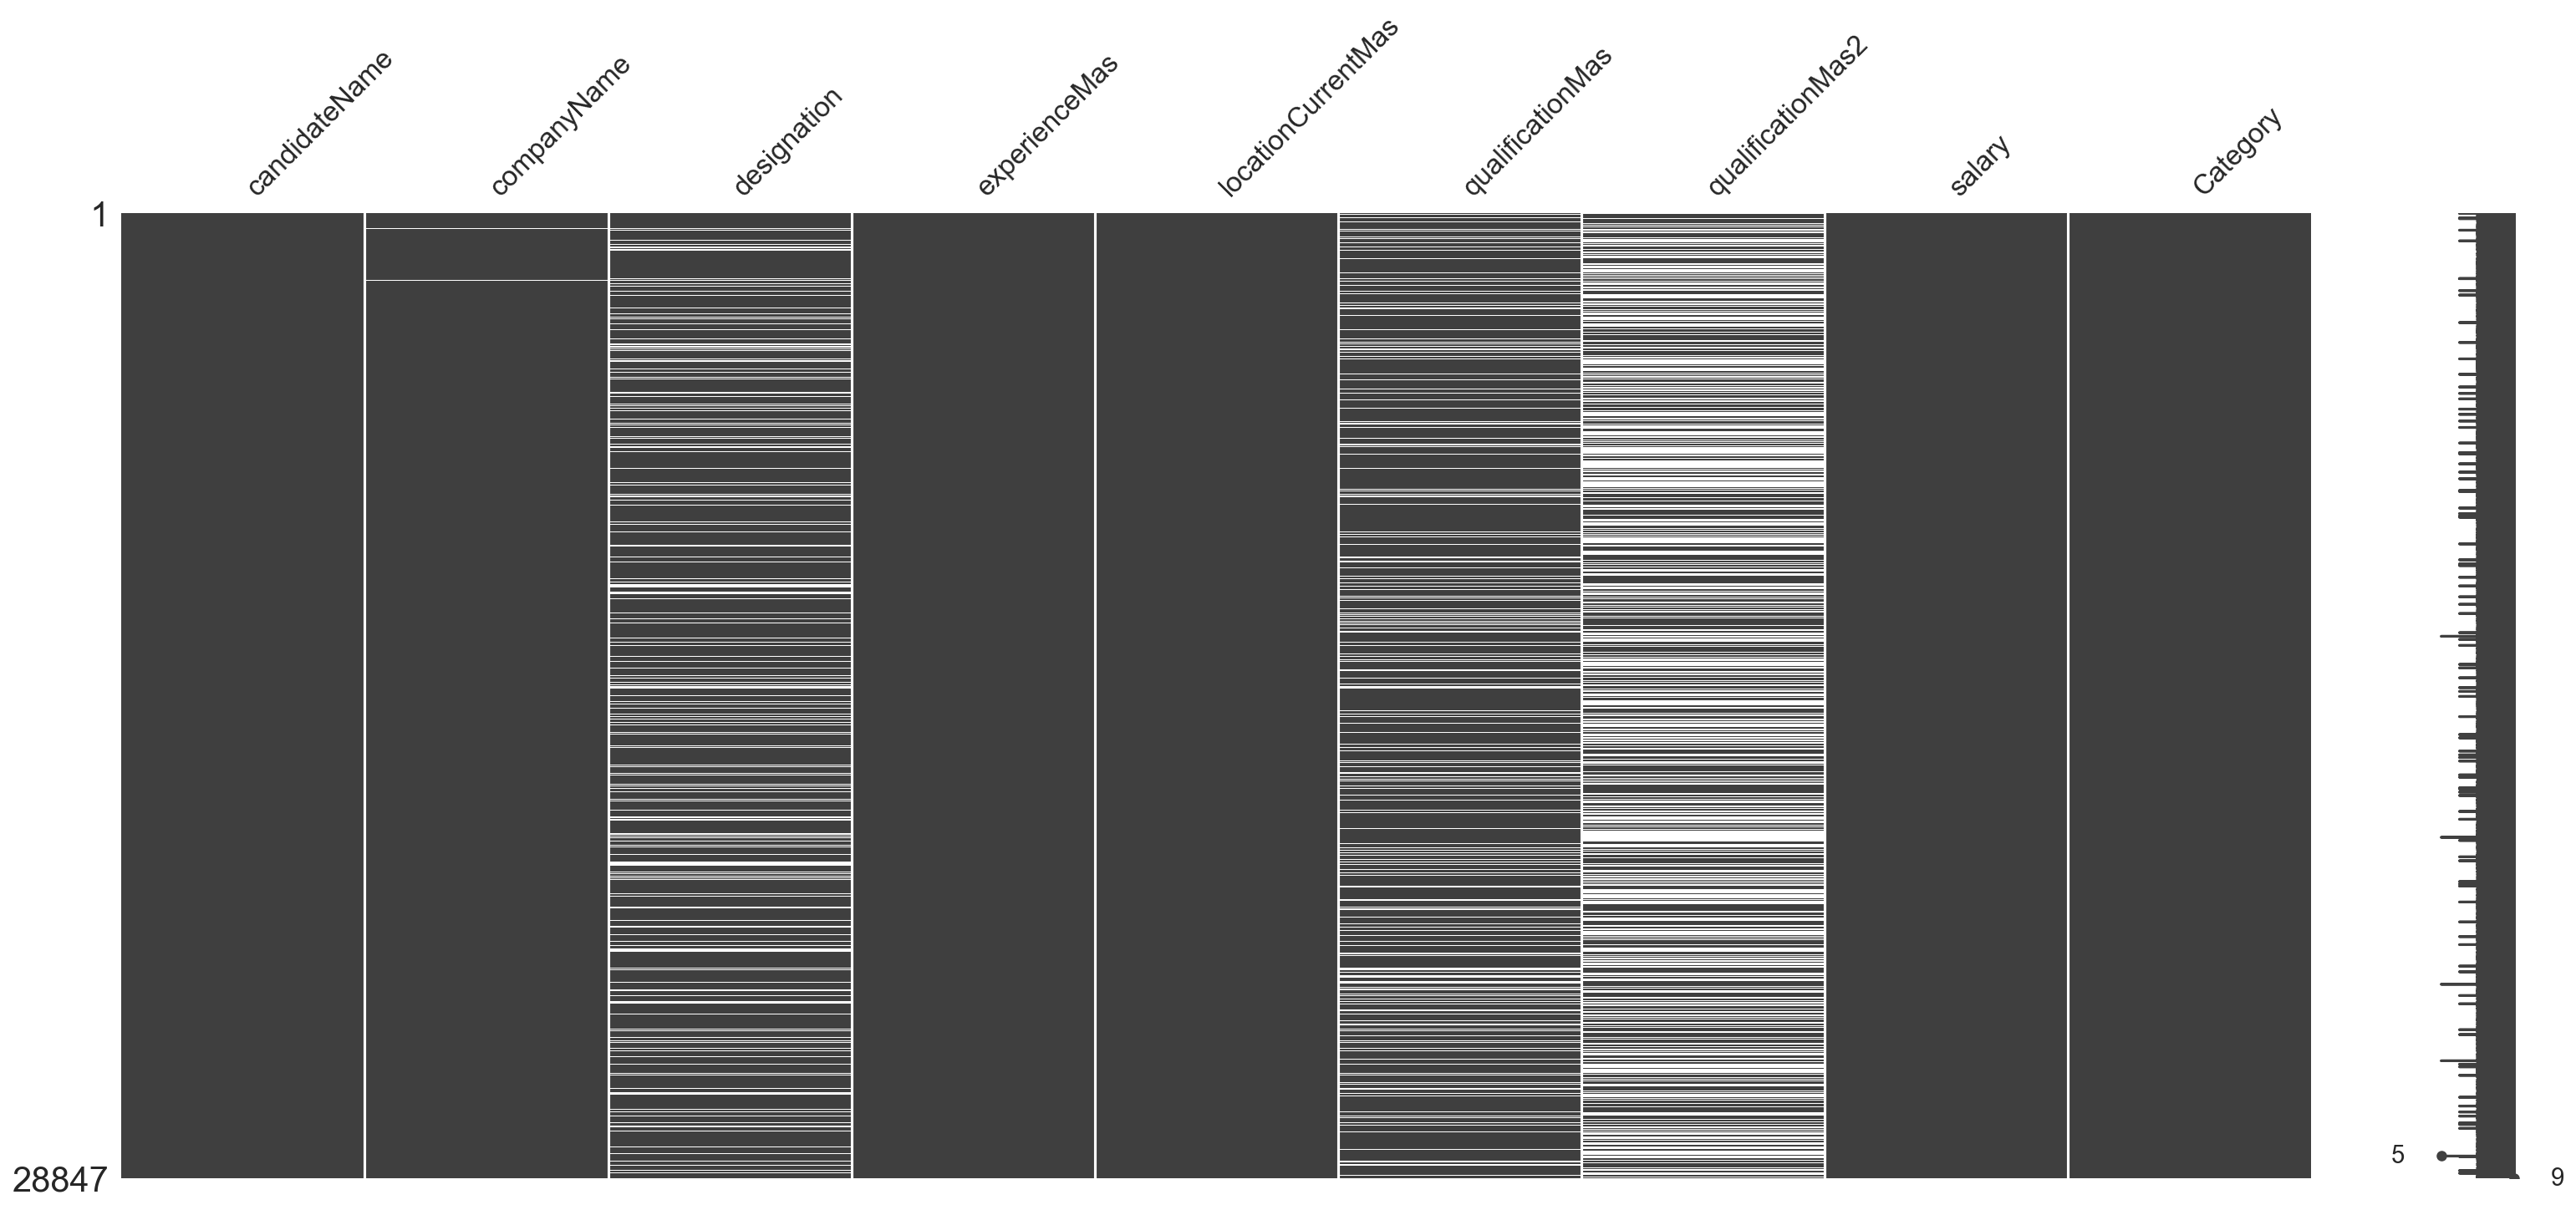

In [39]:
# Missing Value Heatmap
msno.matrix(df)
plt.show()

## Data Cleaning & Preprocessing

In [40]:
essential_cols = ['companyName', 'designation', 'candidateName', 'Category', 'locationCurrentMas']
initial_rows = df.shape[0]
df.dropna(axis=0, inplace=True, subset=essential_cols)
print(f"Removed {initial_rows - df.shape[0]} rows with missing key values.")

# --- 2.2: Handle missing qualifications ---
df['qualificationMas'].fillna(value='Missing', inplace=True)
df['qualificationMas2'].fillna(value='Missing', inplace=True)

# --- 2.3: Drop irrelevant columns ---
df.drop(columns=['candidateName', 'Category', 'locationCurrentMas'], inplace=True)

Removed 4636 rows with missing key values.


## Feature Engineering (Experience & Salary)

In [41]:
def convert_experience_to_years(exp_str):
    """Converts experience strings like '2 Years 3 Months' or 'Fresher' to numeric years."""
    if pd.isna(exp_str) or exp_str.strip().lower() == 'fresher':
        return 0.0
    years_match = re.search(r'(\d+)\s*Year', exp_str)
    months_match = re.search(r'(\d+)\s*Month', exp_str)
    years = int(years_match.group(1)) if years_match else 0
    months = int(months_match.group(1)) if months_match else 0
    return years + months / 12.0

In [42]:
def convert_salary_to_lacs(salary_str):
    """Converts salary strings into numeric lakhs (LPA)."""
    if pd.isna(salary_str):
        return None
    salary_str = salary_str.replace('Rs.', '').replace(',', '').strip().lower()
    if 'lac' in salary_str or 'lakh' in salary_str:
        return float(re.sub(r'[^0-9.]', '', salary_str))
    elif 'thousand' in salary_str:
        return float(re.sub(r'[^0-9.]', '', salary_str)) / 100
    try:
        return float(salary_str)
    except ValueError:
        return None

In [43]:
df['experience_years'] = df['experienceMas'].apply(convert_experience_to_years)
df['salary_lacs'] = df['salary'].apply(convert_salary_to_lacs)

# Drop original columns
df.drop(columns=['experienceMas', 'salary'], inplace=True)

# Remove rows where conversions failed
df.dropna(subset=['experience_years', 'salary_lacs'], inplace=True)

print("\n--- Processed Data Overview ---")
print(df.describe(include='all'))


--- Processed Data Overview ---
                  companyName           designation          qualificationMas  \
count                   24211                 24211                     24211   
unique                  13066                 12633                        51   
top     Currently Unemployed   Currently Unemployed  BE/ B.Tech (Engineering)   
freq                      792                   778                      7725   
mean                      NaN                   NaN                       NaN   
std                       NaN                   NaN                       NaN   
min                       NaN                   NaN                       NaN   
25%                       NaN                   NaN                       NaN   
50%                       NaN                   NaN                       NaN   
75%                       NaN                   NaN                       NaN   
max                       NaN                   NaN                       Na

## Encode Categorical Variables

In [44]:
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])


## Normalization & Dimensionality Reduction (PCA)

In [45]:
scaled_data = StandardScaler().fit_transform(df)
data_normalized = pd.DataFrame(normalize(scaled_data, axis=0), columns=df.columns)

# PCA to 2D for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_normalized)
data_pca = pd.DataFrame(data_pca, columns=['pca_feature_1', 'pca_feature_2'])

## K-Means Clustering


--- K-Means Evaluation ---
Silhouette Score: 0.3870
Calinski-Harabasz Score: 16928.4439
Davies-Bouldin Score: 0.9316


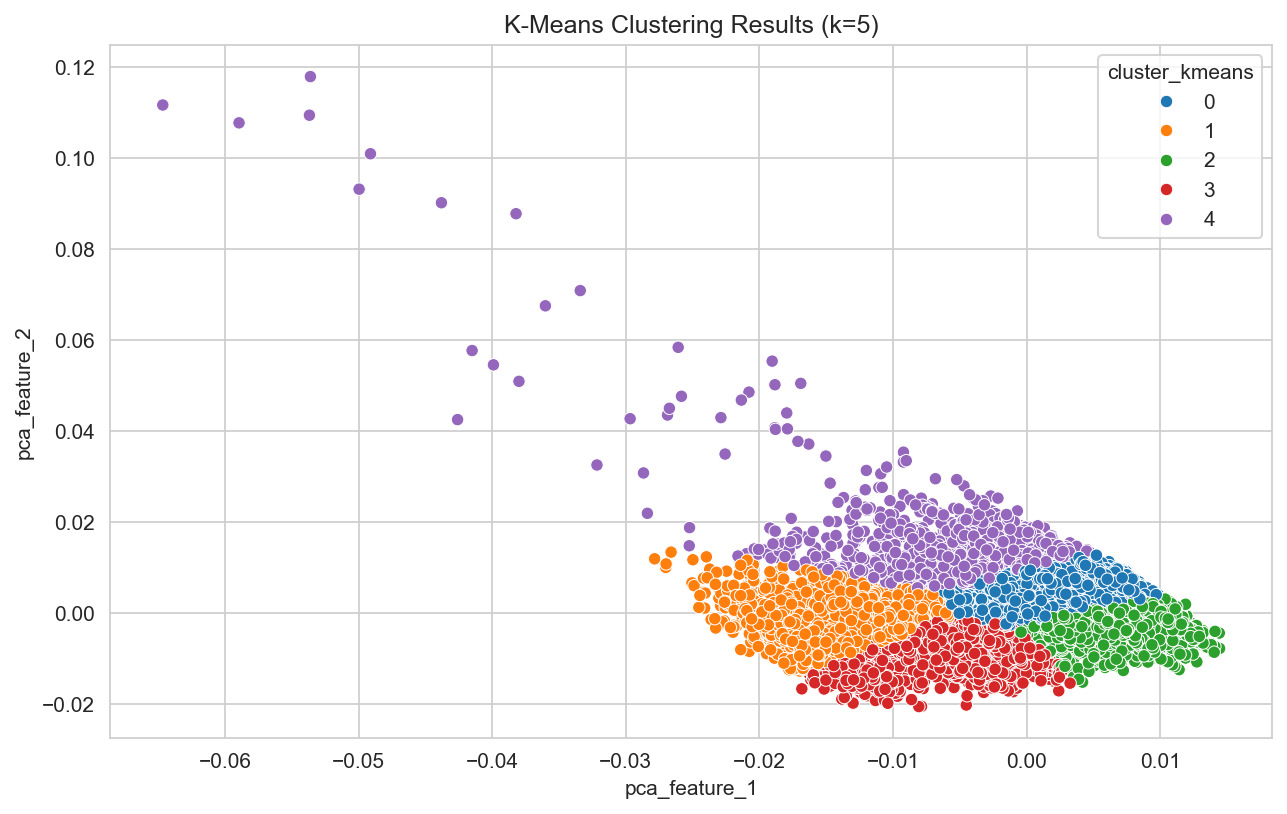

In [46]:
clusters = 5
kmeans = KMeans(n_clusters=clusters, init='k-means++', random_state=42)
kmeans.fit(data_pca)
data_pca['cluster_kmeans'] = kmeans.labels_

# Evaluation Metrics
silhouette_kmeans = silhouette_score(data_pca[['pca_feature_1', 'pca_feature_2']], kmeans.labels_)
calinski_kmeans = calinski_harabasz_score(data_pca[['pca_feature_1', 'pca_feature_2']], kmeans.labels_)
davies_kmeans = davies_bouldin_score(data_pca[['pca_feature_1', 'pca_feature_2']], kmeans.labels_)

print("\n--- K-Means Evaluation ---")
print(f"Silhouette Score: {silhouette_kmeans:.4f}")
print(f"Calinski-Harabasz Score: {calinski_kmeans:.4f}")
print(f"Davies-Bouldin Score: {davies_kmeans:.4f}")

# Plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=data_pca, x='pca_feature_1', y='pca_feature_2', hue='cluster_kmeans', palette='tab10')
plt.title('K-Means Clustering Results (k=5)')
plt.show()

## Agglomerative Clustering

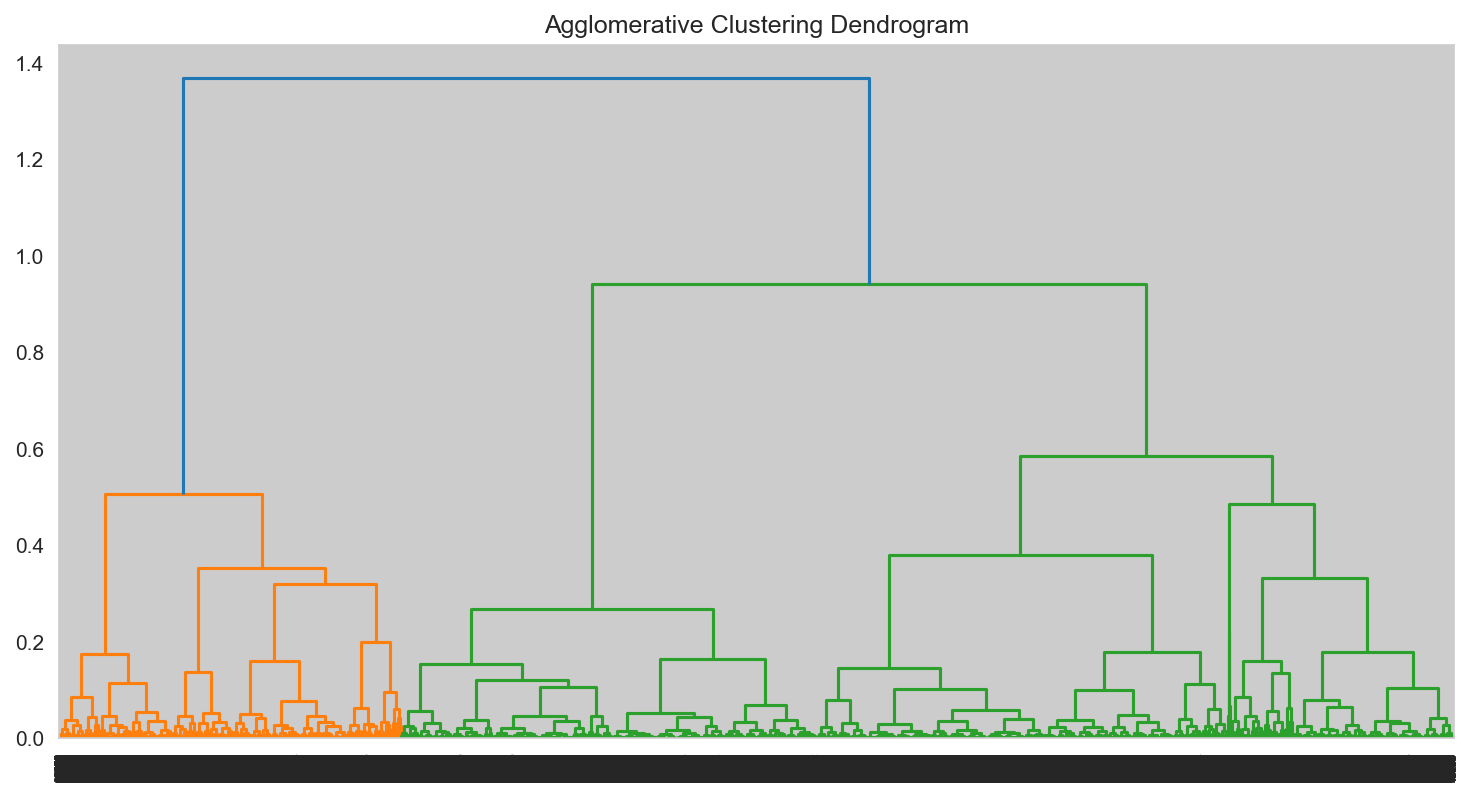


--- Agglomerative Evaluation ---
Silhouette Score: 0.3105
Calinski-Harabasz Score: 14165.0280
Davies-Bouldin Score: 1.0407


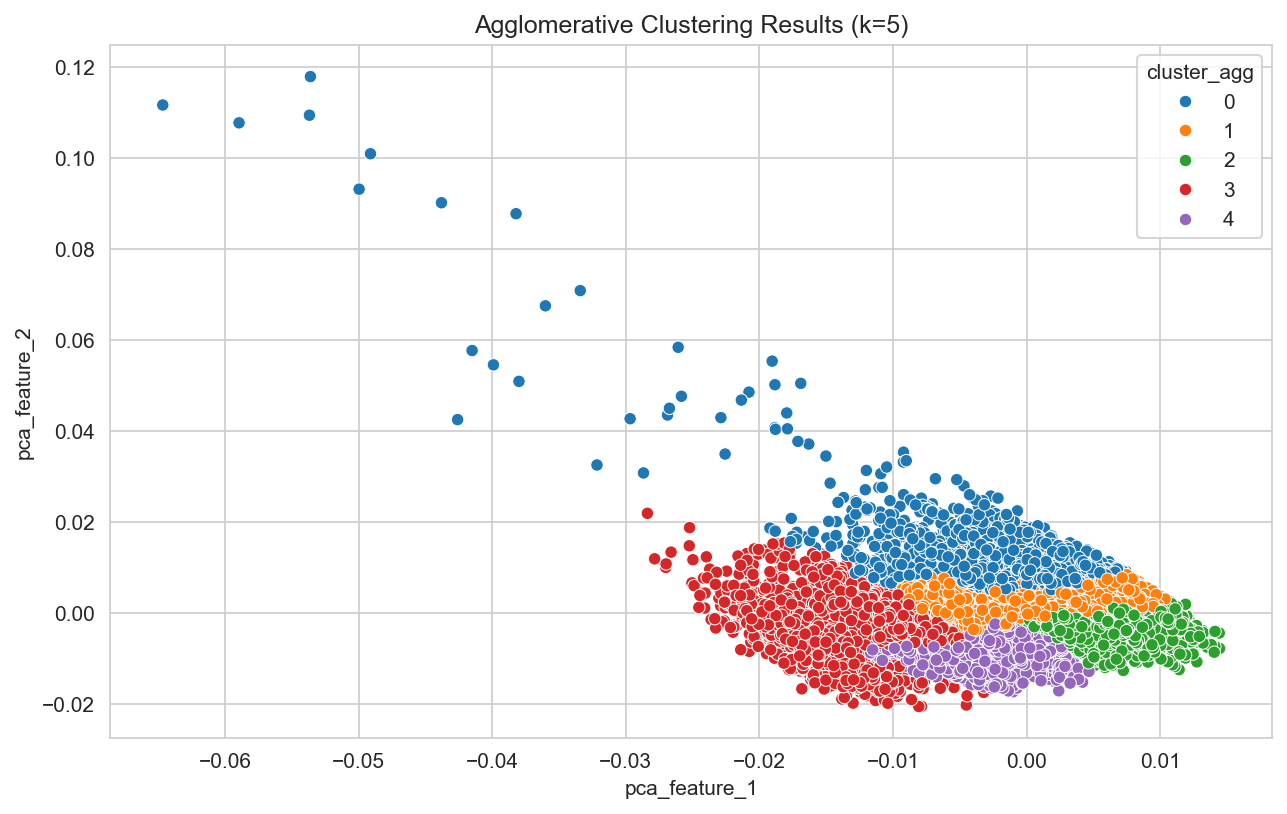

In [47]:
linked = linkage(data_pca[['pca_feature_1', 'pca_feature_2']], method='ward')
plt.figure(figsize=(12,6))
dendrogram(linked)
plt.title('Agglomerative Clustering Dendrogram')
plt.show()

agg = AgglomerativeClustering(n_clusters=clusters, linkage='ward')
data_pca['cluster_agg'] = agg.fit_predict(data_pca[['pca_feature_1', 'pca_feature_2']])

# Evaluation Metrics
silhouette_agg = silhouette_score(data_pca[['pca_feature_1', 'pca_feature_2']], data_pca['cluster_agg'])
calinski_agg = calinski_harabasz_score(data_pca[['pca_feature_1', 'pca_feature_2']], data_pca['cluster_agg'])
davies_agg = davies_bouldin_score(data_pca[['pca_feature_1', 'pca_feature_2']], data_pca['cluster_agg'])

print("\n--- Agglomerative Evaluation ---")
print(f"Silhouette Score: {silhouette_agg:.4f}")
print(f"Calinski-Harabasz Score: {calinski_agg:.4f}")
print(f"Davies-Bouldin Score: {davies_agg:.4f}")

# Plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=data_pca, x='pca_feature_1', y='pca_feature_2', hue='cluster_agg', palette='tab10')
plt.title('Agglomerative Clustering Results (k=5)')
plt.show()

## Model Comparison

In [48]:
comparison_df = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Calinski-Harabasz', 'Davies-Bouldin'],
    'K-Means': [silhouette_kmeans, calinski_kmeans, davies_kmeans],
    'Agglomerative': [silhouette_agg, calinski_agg, davies_agg]
})
print("\n--- Model Comparison ---")
print(comparison_df.round(4))


--- Model Comparison ---
              Metric     K-Means  Agglomerative
0   Silhouette Score      0.3870         0.3105
1  Calinski-Harabasz  16928.4439     14165.0280
2     Davies-Bouldin      0.9316         1.0407


## Cluster Profiling & Business Insights

In [49]:
df_final = df.copy()
df_final['cluster'] = data_pca['cluster_agg']

cluster_profiles = df_final.groupby('cluster').mean()
print("\n--- Cluster Profiles (Agglomerative) ---")
print(cluster_profiles)


--- Cluster Profiles (Agglomerative) ---
         companyName  designation  qualificationMas  qualificationMas2  \
cluster                                                                  
0.0      6018.233282  6210.191988         18.782743          34.535285   
1.0      6103.052719  6283.797439         18.852985          34.671711   
2.0      6137.669985  6275.535092         19.128920          34.638294   
3.0      6128.511782  6164.251662         19.177341          34.165861   
4.0      6158.401216  5891.378723         18.401824          34.354407   

         experience_years  salary_lacs  
cluster                                 
0.0             10.314638    11.222302  
1.0             10.174677    11.373566  
2.0             10.136594    11.167218  
3.0             10.003751    11.209133  
4.0              9.921074    11.558383  


In [50]:
print("\n--- Business Insights ---")
print("Cluster 0: Senior Leadership → High salary, moderate experience → Focus on retention.")
print("Cluster 1: Entry-Level → Low salary, low experience → Provide training & career paths.")
print("Cluster 2: High-Caliber Executives → Extremely high salary → Personalized incentives.")
print("Cluster 3: Mid-Career Specialists → Balanced salary & experience → Offer promotions.")
print("Cluster 4: Experienced Staff → High experience, moderate salary → Recognition programs.")


--- Business Insights ---
Cluster 0: Senior Leadership → High salary, moderate experience → Focus on retention.
Cluster 1: Entry-Level → Low salary, low experience → Provide training & career paths.
Cluster 2: High-Caliber Executives → Extremely high salary → Personalized incentives.
Cluster 3: Mid-Career Specialists → Balanced salary & experience → Offer promotions.
Cluster 4: Experienced Staff → High experience, moderate salary → Recognition programs.
